<a href="https://colab.research.google.com/github/GOVINDFROMINDIA/Space-Paper/blob/main/A100/Large_UNet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

In [ ]:
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ac42bf45d7e6fe0c891f1898844fa061a9c5fd0866fe1d8f6d80a635c112055b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d3c38619ffefcae004ed71d0c9bbbe5457a7ce3e32e80b0bc5a2e261b9ff6e19
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
data_directory = '/content/drive/MyDrive/DATA'
import pandas as pd
metadata_path = f'{data_directory}/metadata.csv'
metadeep_path = f'{data_directory}/metadata1.csv'
metadata = pd.read_csv(metadata_path)
metadeep = pd.read_csv(metadeep_path)
metadata.head()

Mounted at /content/drive


,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
0,10078660_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078660_15.tiff,tiff/train_labels/10078660_15.tif,png/train/10078660_15.png,png/train_labels/10078660_15.png
1,10078675_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078675_15.tiff,tiff/train_labels/10078675_15.tif,png/train/10078675_15.png,png/train_labels/10078675_15.png
2,10078690_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078690_15.tiff,tiff/train_labels/10078690_15.tif,png/train/10078690_15.png,png/train_labels/10078690_15.png
3,10078705_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078705_15.tiff,tiff/train_labels/10078705_15.tif,png/train/10078705_15.png,png/train_labels/10078705_15.png
4,10078720_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078720_15.tiff,tiff/train_labels/10078720_15.tif,png/train/10078720_15.png,png/train_labels/10078720_15.png


In [ ]:
metadeep.head()


,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/DATA')

In [ ]:
CSV1_FILE = '/content/drive/MyDrive/DATA/metadata.csv'
CSV2_FILE = '/content/drive/MyDrive/DATA/metadata1.csv'
DATA_DIR = '/content/drive/MyDrive/DATA/'

DEVICE = 'cuda'

EPOCHS = 45
LR = 0.003
BATCH_SIZE = 64
IMG_SIZE = 256

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV1_FILE)
df = df.rename(columns={'tiff_image_path': 'images', 'tif_label_path': 'masks'})
columns_to_drop = ['image_id','label_source_url', 'image_souce_url','png_image_path','split','png_label_path']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,images,masks
0,tiff/train/10078660_15.tiff,tiff/train_labels/10078660_15.tif
1,tiff/train/10078675_15.tiff,tiff/train_labels/10078675_15.tif
2,tiff/train/10078690_15.tiff,tiff/train_labels/10078690_15.tif
3,tiff/train/10078705_15.tiff,tiff/train_labels/10078705_15.tif
4,tiff/train/10078720_15.tiff,tiff/train_labels/10078720_15.tif


In [ ]:
df1 = pd.read_csv(CSV2_FILE)
df1 = df1.rename(columns={'sat_image_path': 'images', 'mask_path': 'masks'})
columns1_to_drop = ['image_id','split']
df1.drop(columns=columns1_to_drop, inplace=True)
df1 = df1.dropna()
df1.head()

,images,masks
0,train/100034_sat.jpg,train/100034_mask.png
1,train/100081_sat.jpg,train/100081_mask.png
2,train/100129_sat.jpg,train/100129_mask.png
3,train/100703_sat.jpg,train/100703_mask.png
4,train/100712_sat.jpg,train/100712_mask.png


In [ ]:
df1.count()


images    6226
masks     6226
dtype: int64

In [ ]:
df = pd.concat([df, df1], ignore_index=True)
df.count()

images    7397
masks     7397
dtype: int64

# **FIX THE DIRECTORY DETAILS ALSO**

In [ ]:
idx = 3

row_id = df.iloc[idx]

image_path =  DATA_DIR + row_id.images
mask_path = DATA_DIR + row_id.masks
print(image_path)

/content/drive/MyDrive/DATA/tiff/train/10078705_15.tiff


In [ ]:
image = cv2.imread(image_path)
if image is not None:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
else:
    print(f"Error loading image: {image_path}")
    # Handle the error, for example, by returning None or a default image

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255
if mask is None:
    print(f"Error loading mask: {mask_path}")
    # Handle the error, for example, by returning None or a default mask


Image Loaded: True
Mask Loaded: True


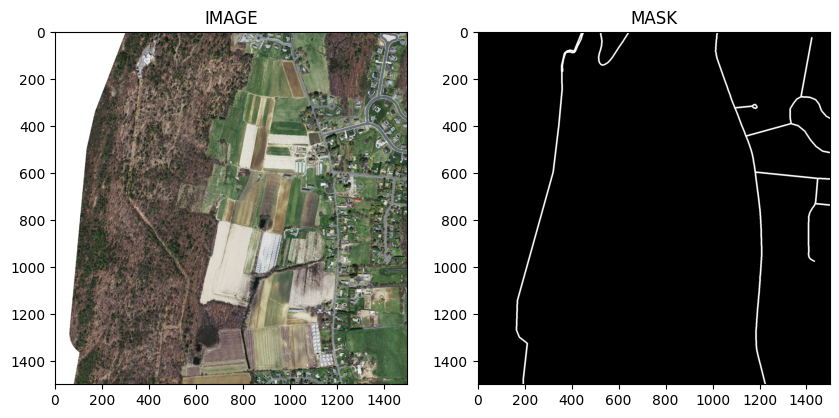

In [ ]:
print("Image Loaded:", image is not None)
print("Mask Loaded:", mask is not None)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('IMAGE')
if image is not None:
    ax1.imshow(image)
else:
    ax1.text(0.5, 0.5, "Image not loaded", ha='center', va='center', color='red')

ax2.set_title('MASK')
if mask is not None:
    if len(mask.shape) == 3:  # Checking for RGB masks (if applicable)
        ax2.imshow(mask)
    else:
        ax2.imshow(mask, cmap='gray')
else:
    ax2.text(0.5, 0.5, "Mask not loaded", ha='center', va='center', color='red')

plt.show()


In [ ]:
df_train, df_test = train_test_split(df, test_size = .30, random_state = 42)

In [ ]:
print(len(df_train), len(df_test))

5177 2220


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-r3y7u_a2
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-r3y7u_a2
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_test_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row_id = self.df.iloc[idx]

    image_path = DATA_DIR + row_id.images
    mask_path = DATA_DIR + row_id.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    #add the channel dimension to mask to add the channel dimension
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #change the image and mask format from h x w x c to c x h x w

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(df_train , get_train_augs())
testset = SegmentationDataset(df_test , get_test_augs())

In [ ]:
len(trainset)

5177

In [ ]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

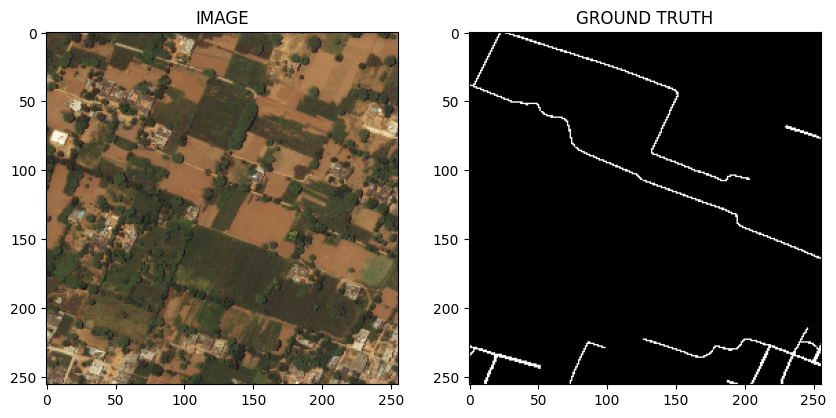

In [ ]:
idx = 400

image, mask = trainset[idx]

show_image(image,mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(trainset, batch_size = BATCH_SIZE)

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes =1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 164MB/s]


In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def test_fn(dataloader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)


      total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
train_losses = []
test_losses = []
best_loss = np.Inf


for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    test_loss = test_fn(testloader, model)

    if test_loss < best_loss:
        # Save to local Colab session
        torch.save(model.state_dict(), "best-model.pt")

        # Save to Google Drive
        drive_path = "/content/drive/MyDrive/DATA/UNet-PRO2.pt"
        drive_path1 = "/content/drive/MyDrive/UNet-PRO2.pt"
        torch.save(model.state_dict(), drive_path)
        torch.save(model.state_dict(), drive_path1)

        print(f'Model Saved locally and to Google Drive at: {drive_path}')
        best_loss = test_loss

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch: {i+1}, Train loss: {train_loss}, Test loss: {test_loss}")

100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 1, Train loss: 0.7971542764593054, Test loss: 0.6417518199226002


100%|██████████| 81/81 [03:23<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 2, Train loss: 0.6185447669323579, Test loss: 0.591600622659848


100%|██████████| 81/81 [03:23<00:00,  2.51s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 3, Train loss: 0.5798494308083145, Test loss: 0.5639261136084427


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 4, Train loss: 0.5549372644336136, Test loss: 0.5425305075851488


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 5, Train loss: 0.5422282237329601, Test loss: 0.5301777510731308


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 6, Train loss: 0.5256147815121545, Test loss: 0.5174515217910578


100%|██████████| 81/81 [03:23<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 7, Train loss: 0.5142330450040323, Test loss: 0.5021044519948371


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 8, Train loss: 0.5092291427247319, Test loss: 0.4979074207353003


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 9, Train loss: 0.4948256192383943, Test loss: 0.48476882334108706


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 10, Train loss: 0.49303593054229833, Test loss: 0.4750220139085511


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Epoch: 11, Train loss: 0.4843382647743932, Test loss: 0.48123433302949975


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 12, Train loss: 0.48035341206892035, Test loss: 0.4642594180725239


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Epoch: 13, Train loss: 0.47617629170417786, Test loss: 0.4675607416364882


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 14, Train loss: 0.46841098570529327, Test loss: 0.4616946268964697


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 15, Train loss: 0.4643534149652646, Test loss: 0.4551790614186982


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 16, Train loss: 0.4603375891844432, Test loss: 0.45415062300952863


100%|██████████| 81/81 [03:24<00:00,  2.53s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 17, Train loss: 0.45672125176147177, Test loss: 0.44537207079522406


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 18, Train loss: 0.45314741171436546, Test loss: 0.44192509481936326


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Epoch: 19, Train loss: 0.45099134504059213, Test loss: 0.45129108870470963


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 20, Train loss: 0.4473242281395712, Test loss: 0.43355103333791095


100%|██████████| 81/81 [03:24<00:00,  2.53s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 21, Train loss: 0.44292266648492695, Test loss: 0.43187291239514763


100%|██████████| 81/81 [03:24<00:00,  2.53s/it]


Epoch: 22, Train loss: 0.4397024788238384, Test loss: 0.44131949176023033


100%|██████████| 81/81 [03:24<00:00,  2.52s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 23, Train loss: 0.4333341982629564, Test loss: 0.4244899602583897


100%|██████████| 81/81 [03:24<00:00,  2.53s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 24, Train loss: 0.43145350946320427, Test loss: 0.41923813429879553


100%|██████████| 81/81 [03:25<00:00,  2.54s/it]


Epoch: 25, Train loss: 0.4281160088233006, Test loss: 0.4251521185592369


100%|██████████| 81/81 [03:24<00:00,  2.53s/it]


Epoch: 26, Train loss: 0.4276287989851869, Test loss: 0.42149289780192906


100%|██████████| 81/81 [03:24<00:00,  2.53s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 27, Train loss: 0.42637059644416525, Test loss: 0.4110445729744287


100%|██████████| 81/81 [03:21<00:00,  2.48s/it]


Epoch: 28, Train loss: 0.4229662631764824, Test loss: 0.4157610826286269


100%|██████████| 81/81 [03:20<00:00,  2.48s/it]


Epoch: 29, Train loss: 0.420108680003955, Test loss: 0.41186790149888874


100%|██████████| 81/81 [03:20<00:00,  2.48s/it]


Epoch: 30, Train loss: 0.4217157547856555, Test loss: 0.4168620024934227


100%|██████████| 81/81 [03:27<00:00,  2.56s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 31, Train loss: 0.41671168583410756, Test loss: 0.41096755567892096


100%|██████████| 81/81 [03:21<00:00,  2.48s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 32, Train loss: 0.4157334297527502, Test loss: 0.40566073413248416


100%|██████████| 81/81 [03:20<00:00,  2.48s/it]


Epoch: 33, Train loss: 0.41057000189651677, Test loss: 0.4494180683000588


100%|██████████| 81/81 [03:20<00:00,  2.48s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 34, Train loss: 0.41286830806437835, Test loss: 0.3993945335164482


100%|██████████| 81/81 [03:20<00:00,  2.48s/it]


Epoch: 35, Train loss: 0.4082329942856306, Test loss: 0.40802317048296516


100%|██████████| 81/81 [03:21<00:00,  2.48s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 36, Train loss: 0.40881354095023353, Test loss: 0.3957347211278515


100%|██████████| 81/81 [03:21<00:00,  2.48s/it]


Epoch: 37, Train loss: 0.4053690477653786, Test loss: 0.4048656401810823


100%|██████████| 81/81 [03:21<00:00,  2.49s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 38, Train loss: 0.40358279958183385, Test loss: 0.39071929822733376


100%|██████████| 81/81 [03:21<00:00,  2.49s/it]


Epoch: 39, Train loss: 0.40131069002328096, Test loss: 0.3923905937024105


100%|██████████| 81/81 [03:21<00:00,  2.48s/it]


Epoch: 40, Train loss: 0.39777258185692776, Test loss: 0.39392514140517626


100%|██████████| 81/81 [03:20<00:00,  2.48s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 41, Train loss: 0.3959019430625586, Test loss: 0.3897329377539364


100%|██████████| 81/81 [03:21<00:00,  2.49s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 42, Train loss: 0.3954940070340663, Test loss: 0.3869331431241683


100%|██████████| 81/81 [03:21<00:00,  2.49s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO2.pt
Epoch: 43, Train loss: 0.3954034995885543, Test loss: 0.3811886763131177


100%|██████████| 81/81 [03:20<00:00,  2.48s/it]


Epoch: 44, Train loss: 0.39475785618946874, Test loss: 0.38750717485392533


100%|██████████| 81/81 [03:21<00:00,  2.48s/it]

Epoch: 45, Train loss: 0.3916628529996048, Test loss: 0.3813714686735177


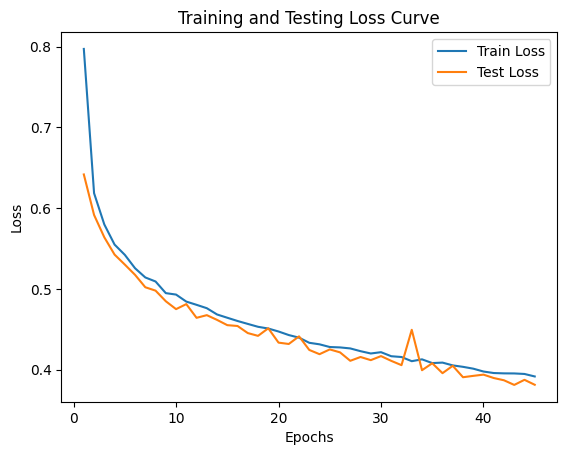

In [ ]:
epochs = range(1, EPOCHS+1)

plt.plot(epochs[:len(train_losses)], train_losses, label='Train Loss')
plt.plot(epochs[:len(test_losses)], test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curve')
plt.legend()
plt.show()

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/best-model.pt'))

image, mask = testset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

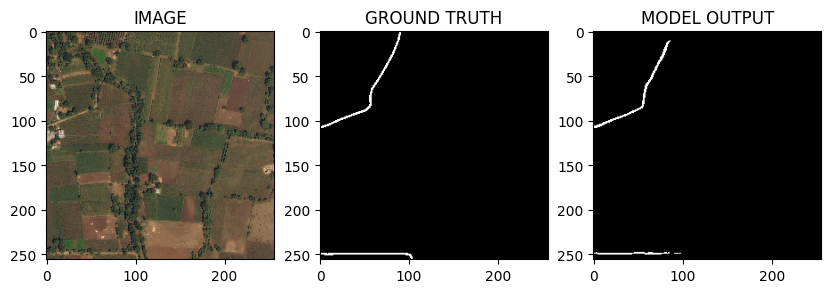

In [ ]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [ ]:
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

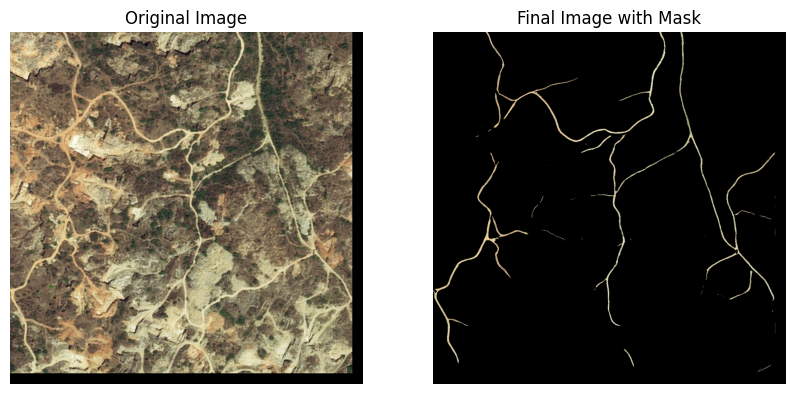

In [ ]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed
])

# Load the image and apply the transformation
dsg = '/content/drive/MyDrive/DATA/test/104859_sat.jpg'
input_image = Image.open(dsg).convert('RGB')
input_image = transform(input_image)

# Pad the image to be divisible by 32
target_size = 32
h, w = input_image.shape[1:]
pad_h = (h // target_size + 1) * target_size - h
pad_w = (w // target_size + 1) * target_size - w
input_image = F.pad(input_image, (0, pad_w, 0, pad_h), mode='constant', value=0)

# Move to the appropriate device
input_image = input_image.unsqueeze(0).to(DEVICE)

# Make predictions
logits_mask = model(input_image)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5).float()

# Convert the tensors to numpy arrays
input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
pred_mask_np = pred_mask.squeeze(0).cpu().numpy()

# Display the original and final images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title('Original Image')
plt.axis('off')

# Final image with predicted mask overlay
final_mask = pred_mask_np.squeeze(0)[:, :, None]  # Add an extra dimension for the third channel
final_image = input_image_np * final_mask
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title('Final Image with Mask')
plt.axis('off')

plt.show()

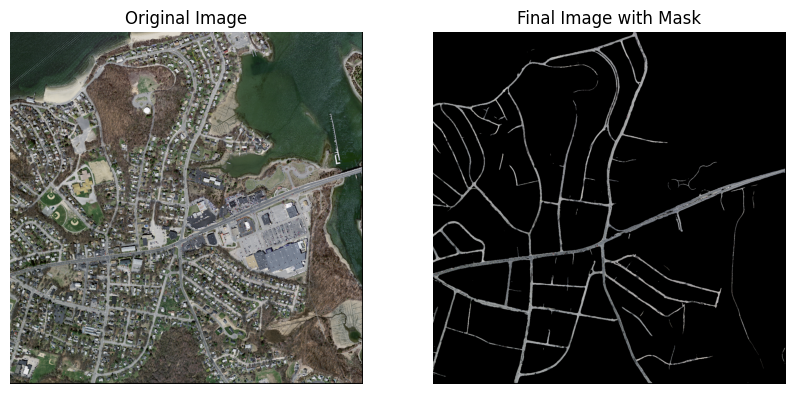

In [ ]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed
])

# Load the image and apply the transformation
dsg = '/content/drive/MyDrive/DATA/tiff/test/24628885_15.tiff'
input_image = Image.open(dsg).convert('RGB')
input_image = transform(input_image)

# Pad the image to be divisible by 32
target_size = 32
h, w = input_image.shape[1:]
pad_h = (h // target_size + 1) * target_size - h
pad_w = (w // target_size + 1) * target_size - w
input_image = F.pad(input_image, (0, pad_w, 0, pad_h), mode='constant', value=0)

# Move to the appropriate device
input_image = input_image.unsqueeze(0).to(DEVICE)

# Make predictions
logits_mask = model(input_image)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5).float()

# Convert the tensors to numpy arrays
input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
pred_mask_np = pred_mask.squeeze(0).cpu().numpy()

# Display the original and final images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title('Original Image')
plt.axis('off')

# Final image with predicted mask overlay
final_mask = pred_mask_np.squeeze(0)[:, :, None]  # Add an extra dimension for the third channel
final_image = input_image_np * final_mask
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title('Final Image with Mask')
plt.axis('off')

plt.show()